In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import keras_tuner as kt

import joblib

import warnings
warnings.filterwarnings('ignore')

# For display purposes
pd.set_option('display.expand_frame_repr', False)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Load data
ETH_book1 = pd.DataFrame(pd.read_pickle('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/hyp_data/ETH/ETH_book_20241108.pkl'))
ETH_book2 = pd.DataFrame(pd.read_pickle('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/hyp_data/ETH/ETH_book_20241109.pkl'))
ETH_book3 = pd.DataFrame(pd.read_pickle('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/hyp_data/ETH/ETH_book_20241110.pkl'))
ETH_trade1 = pd.DataFrame(pd.read_pickle('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/hyp_data/ETH/ETH_trade_20241108.pkl'))
ETH_trade2 = pd.DataFrame(pd.read_pickle('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/hyp_data/ETH/ETH_trade_20241109.pkl'))
ETH_trade3 = pd.DataFrame(pd.read_pickle('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/hyp_data/ETH/ETH_trade_20241110.pkl'))

ETH_book = pd.concat([ETH_book1, ETH_book2, ETH_book3], ignore_index=True)
ETH_trades = pd.concat([ETH_trade1, ETH_trade2, ETH_trade3], ignore_index=True)

# Inspect the structure of the data
print(f"LOB\n{ETH_book.head()}\n")
print(f"Trades\n{ETH_trades.head()}\n")

LOB
  coin                                             levels           time
0  ETH  [[{'px': '2889.8', 'sz': '78.3793', 'n': 17}, ...  1731017421096
1  ETH  [[{'px': '2889.8', 'sz': '78.3793', 'n': 17}, ...  1731017421096
2  ETH  [[{'px': '2889.8', 'sz': '78.3793', 'n': 17}, ...  1731017421096
3  ETH  [[{'px': '2889.8', 'sz': '78.3793', 'n': 17}, ...  1731017421096
4  ETH  [[{'px': '2889.8', 'sz': '78.3793', 'n': 17}, ...  1731017421096

Trades
  coin side      px      sz           time                                               hash               tid
0  ETH    B  2889.4  3.8707  1731017419162  0xd889db75c030f8231be004163e12ad0110001ce56e0c...  1023556703028983
1  ETH    B  2889.4  3.8707  1731017419162  0xd889db75c030f8231be004163e12ad0110001ce56e0c...  1023556703028983
2  ETH    B  2889.4  3.8707  1731017419162  0xd889db75c030f8231be004163e12ad0110001ce56e0c...  1023556703028983
3  ETH    B  2889.4  3.8707  1731017419162  0xd889db75c030f8231be004163e12ad0110001ce56e0c...  1023556

In [4]:
LOB_LEVELS = 10
bid_price_cols = [f'BidPrice_{i+1}' for i in range(LOB_LEVELS)]
bid_volume_cols = [f'BidVolume_{i+1}' for i in range(LOB_LEVELS)]
bid_orders_cols = [f'BidOrders_{i+1}' for i in range(LOB_LEVELS)]
ask_price_cols = [f'AskPrice_{i+1}' for i in range(LOB_LEVELS)]
ask_volume_cols = [f'AskVolume_{i+1}' for i in range(LOB_LEVELS)]
ask_orders_cols = [f'AskOrders_{i+1}' for i in range(LOB_LEVELS)]

In [5]:
levels = ETH_book['levels'].tolist()
bids = [row[0] for row in levels]
asks = [row[1] for row in levels]

def extract_prices_sizes_n(entries, levels=LOB_LEVELS):
    px = [float(entry['px']) for entry in entries[:levels]]
    sz = [float(entry['sz']) for entry in entries[:levels]]
    n_orders = [int(entry['n']) for entry in entries[:levels]]
    px += [np.nan]*(levels - len(px))
    sz += [np.nan]*(levels - len(sz))
    n_orders += [np.nan]*(levels - len(n_orders))
    return px, sz, n_orders

bid_px, bid_sz, bid_n = zip(*[extract_prices_sizes_n(bid) for bid in bids])
ask_px, ask_sz, ask_n = zip(*[extract_prices_sizes_n(ask) for ask in asks])

bid_px_df = pd.DataFrame(bid_px, columns=bid_price_cols)
bid_sz_df = pd.DataFrame(bid_sz, columns=bid_volume_cols)
bid_n_df = pd.DataFrame(bid_n, columns=bid_orders_cols)
ask_px_df = pd.DataFrame(ask_px, columns=ask_price_cols)
ask_sz_df = pd.DataFrame(ask_sz, columns=ask_volume_cols)
ask_n_df = pd.DataFrame(ask_n, columns=ask_orders_cols)

lob_expanded = pd.concat([bid_px_df, bid_sz_df, bid_n_df, ask_px_df, ask_sz_df, ask_n_df], axis=1)
eth_book = pd.concat([ETH_book.drop(columns=['levels']).reset_index(drop=True), 
                      lob_expanded.reset_index(drop=True)], axis=1)

eth_book['MidPrice'] = (eth_book['AskPrice_1'] + eth_book['BidPrice_1']) / 2
eth_book['MidPrice_Next'] = eth_book['MidPrice'].shift(-1)
eth_book['PriceMove'] = 0
eth_book.loc[eth_book['MidPrice_Next'] > eth_book['MidPrice'], 'PriceMove'] = 1
eth_book.loc[eth_book['MidPrice_Next'] < eth_book['MidPrice'], 'PriceMove'] = -1
eth_book = eth_book.dropna(subset=['MidPrice_Next'])

print(eth_book.head())

  coin           time  BidPrice_1  BidPrice_2  BidPrice_3  BidPrice_4  BidPrice_5  BidPrice_6  BidPrice_7  BidPrice_8  ...  AskOrders_4  AskOrders_5  AskOrders_6  AskOrders_7  AskOrders_8  AskOrders_9  AskOrders_10  MidPrice  MidPrice_Next  PriceMove
0  ETH  1731017421096      2889.8      2889.7      2889.6      2889.5      2889.4      2889.3      2889.2      2889.1  ...            1            1            4            3            4            3             3   2889.85        2889.85          0
1  ETH  1731017421096      2889.8      2889.7      2889.6      2889.5      2889.4      2889.3      2889.2      2889.1  ...            1            1            4            3            4            3             3   2889.85        2889.85          0
2  ETH  1731017421096      2889.8      2889.7      2889.6      2889.5      2889.4      2889.3      2889.2      2889.1  ...            1            1            4            3            4            3             3   2889.85        2889.85        

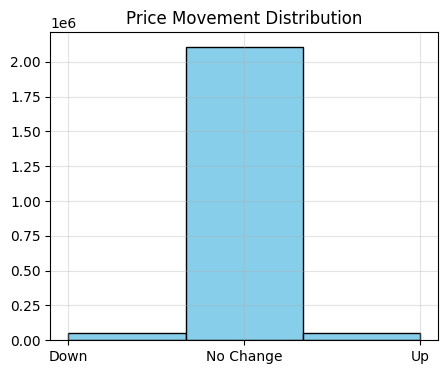

Label distribution
 PriceMove
 0    2107456
 1      54113
-1      53631
Name: count, dtype: int64


In [6]:
# Distribution of labels
plt.figure(figsize=(5, 4))
plt.hist(eth_book['PriceMove'], bins=3, color='skyblue', edgecolor='black')
plt.title('Price Movement Distribution')
plt.xticks([-1, 0, 1], labels=['Down', 'No Change', 'Up'])
plt.grid(alpha=0.35)
plt.show()

# Check the distribution of labels, which is higly imbalanced
print("Label distribution\n", eth_book['PriceMove'].value_counts())

## <center> Feature Engineering

### Imbalance


Order flow imbalance, defined as
$$
\text{I}_i = \frac{V_{\text{bid}_i}}{V_{\text{bid}_i} + V_{\text{ask}_i}}
$$
at each depth level $i$, captures the pressure on either side of the book. A high positive imbalance often signals upward pressure, whereas a negative imbalance suggests downward pressure.


In [7]:
# Imbalance features
for level in range(1, LOB_LEVELS+1):
    b_vol = eth_book[f'BidVolume_{level}']
    a_vol = eth_book[f'AskVolume_{level}']
    eth_book[f'Imbalance_{level}'] = (b_vol - a_vol) / (b_vol + a_vol)

eth_book['Imbalance_Total'] = (eth_book[[f'BidVolume_{i}' for i in range(1, LOB_LEVELS+1)]].sum(axis=1) -
    eth_book[[f'AskVolume_{i}' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)
) / (
    eth_book[[f'BidVolume_{i}' for i in range(1, LOB_LEVELS+1)]].sum(axis=1) +
    eth_book[[f'AskVolume_{i}' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)
)

for level in range(1, LOB_LEVELS+1):
    eth_book[f'BidOrders_{level}_Change'] = eth_book[f'BidOrders_{level}'].diff()
    eth_book[f'AskOrders_{level}_Change'] = eth_book[f'AskOrders_{level}'].diff()

### Trade data processing

In [8]:
# Trade data processing
ETH_trades['sz'] = ETH_trades['sz'].astype(float)
ETH_trades['side'] = ETH_trades['side'].astype(str)
ETH_trades['time'] = pd.to_datetime(ETH_trades['time'], unit='ms')
eth_book.reset_index(inplace=True)
eth_book['time'] = pd.to_datetime(eth_book['time'], unit='ms')

ETH_trades.set_index('time', inplace=True)
eth_book.set_index('time', inplace=True)

eth_book.fillna(0, inplace=True)
eth_book['BidArrivalRate'] = eth_book[[f'BidOrders_{i}_Change' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)
eth_book['AskArrivalRate'] = eth_book[[f'AskOrders_{i}_Change' for i in range(1, LOB_LEVELS+1)]].sum(axis=1)

### Aggregate trade data

By merging trade data with the LOB, we add context such as buy/sell volume and the number of recent trades. This can highlight aggressiveness in the market and help identify shifts in sentiment and liquidity.

In [9]:
# Aggregate trade data
eth_book['TradeVolume_Buy'] = 0.0
eth_book['TradeVolume_Sell'] = 0.0
eth_book['NumTrades_Buy'] = 0
eth_book['NumTrades_Sell'] = 0
trade_resampled = ETH_trades.groupby('time').agg({'sz':'sum','side':lambda x: x.value_counts().to_dict()})
eth_book = eth_book.merge(trade_resampled, left_index=True, right_index=True, how='left')
eth_book['sz'].fillna(0, inplace=True)
eth_book['side'] = eth_book['side'].apply(lambda x: {} if pd.isnull(x) else x)
eth_book['TradeVolume_Buy'] = eth_book.apply(lambda row: row['sz'] if 'B' in row['side'] else 0, axis=1)
eth_book['TradeVolume_Sell'] = eth_book.apply(lambda row: row['sz'] if 'S' in row['side'] else 0, axis=1)
eth_book['NumTrades_Buy'] = eth_book['side'].apply(lambda x: x.get('B',0))
eth_book['NumTrades_Sell'] = eth_book['side'].apply(lambda x: x.get('S',0))
eth_book.drop(columns=['sz','side'], inplace=True)

### Binance trade data

We incorporate data from Binance to highlight large trades and total volume flow. This cross-exchange information can help detect shifts in the global market microstructure.

In [10]:
# Binance data
binance_trades1 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-08.csv', header=None)
binance_trades2 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-09.csv', header=None)
binance_trades3 = pd.read_csv('C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-11-10.csv', header=None)

binance_trades = pd.concat([binance_trades1, binance_trades2, binance_trades3])
binance_trades = binance_trades.rename(columns={0:'ID', 1:'Price', 2:'Quantity', 3:'Quote_Quantity', 4:'Time', 5:'Is_Buyer_Make', 6:'Ignore'})
binance_trades['Time'] = pd.to_datetime(binance_trades['Time'], unit='ms')
binance_trades.set_index('Time', inplace=True)

threshold = binance_trades['Quantity'].quantile(0.95)
binance_trades['LargeTrade'] = (binance_trades['Quantity'] >= threshold).astype(int)
binance_agg = binance_trades.groupby('Time').agg({'Quantity':'sum','LargeTrade':'sum'})
eth_book = eth_book.merge(binance_agg, how='left', left_index=True, right_index=True)
eth_book['Quantity'].fillna(0, inplace=True)
eth_book['LargeTrade'].fillna(0, inplace=True)
eth_book.rename(columns={'Quantity':'BinanceTotalVolume','LargeTrade':'BinanceLargeTradeCount'}, inplace=True)

In [11]:
# Aggregate volumes for LOB levels 3 to 10
eth_book['AskVolume_3to10'] = eth_book[[f'AskVolume_{i}' for i in range(3, 11)]].sum(axis=1)
eth_book['BidVolume_3to10'] = eth_book[[f'BidVolume_{i}' for i in range(3, 11)]].sum(axis=1)
drop_cols = [f'AskVolume_{i}' for i in range(3, 11)] + [f'BidVolume_{i}' for i in range(3, 11)]
eth_book.drop(columns=drop_cols, inplace=True)

# Lag BinanceTotalVolume to avoid lookahead
eth_book['Lagged_BinanceTotalVolume'] = eth_book['BinanceTotalVolume'].shift(1).fillna(0)
eth_book['Lagged_BinanceLargeTradeCount'] = eth_book['BinanceLargeTradeCount'].shift(1).fillna(0)

In [12]:
# Rolling aggregates & event flags
window_sizes = [5, 20]  # Example windows: 5 ticks and 20 ticks
for w in window_sizes:
    eth_book[f'BinanceTotalVolume_rollingSum_{w}'] = (
        eth_book['Lagged_BinanceTotalVolume'].rolling(window=w, min_periods=1).sum()
    )
    eth_book[f'BinanceLargeTradeCount_rollingSum_{w}'] = (
        eth_book['Lagged_BinanceLargeTradeCount'].rolling(window=w, min_periods=1).sum()
    )
    # Event flags: Has there been a large trade in the last w ticks?
    eth_book[f'LargeTrade_flag_{w}'] = (eth_book[f'BinanceLargeTradeCount_rollingSum_{w}'] > 0).astype(int)

### Additional features

Derived Features (Spread, Relative Spread, Microprice)

- **Spread**: $A_1 - B_1$ measures immediate liquidity cost.
- **Relative Spread**: $\frac{A_1 - B_1}{M}$ normalizes the spread by the mid-price $M$.
- **Microprice**:
$$
\text{Microprice} = I \cdot A_1 + (1 - I) \cdot B_1
$$
This provides a volume-weighted estimate of the fair price, giving more insight than a simple mid-price.


In [13]:
# Spread and relative spread
eth_book['Spread'] = eth_book['AskPrice_1'] - eth_book['BidPrice_1']
eth_book['RelativeSpread'] = eth_book['Spread'] / eth_book['MidPrice']

# Microprice
eth_book['Microprice'] = (
    eth_book['Imbalance_1']*eth_book['AskPrice_1'] + (1 - eth_book['Imbalance_1'])*eth_book['BidPrice_1']
)

# Volume-weighted average price for top level
eth_book['VWAP'] = (eth_book['AskPrice_1']*eth_book['AskVolume_1'] + eth_book['BidPrice_1']*eth_book['BidVolume_1']) / (eth_book['AskVolume_1']+eth_book['BidVolume_1'])

### Label smoothing

Instead of using the immediate mid-price change for labeling, we apply smoothing by looking at a moving average over a window $ S $. Defining
$$
m_{\text{prev}} = \frac{1}{S}\sum_{i=0}^{S-1} P_{t-i}, \quad m_{\text{next}} = \frac{1}{S}\sum_{i=1}^{S} P_{t+i}
$$
where $ M_t $ is the mid-price at time $ t $. The price move is determined by the relative difference $\frac{m_{\text{next}} - m_{\text{prev}}}{m_{\text{prev}}}$. Such smoothing reduces label noise and more consistently captures directional price trends. The parameter $\alpha$ determines the threshold for price movement.

In [14]:
S = 10
alpha = 0.00001

m_prev = eth_book['MidPrice'].rolling(window=S, min_periods=1).mean()
m_next = eth_book['MidPrice'].shift(-S).rolling(window=S, min_periods=1).mean()

# Smoothed prices
lt = (m_next - m_prev) / m_prev

# Define labels
eth_book['SmoothedPriceMove'] = 0  # Default to neutral
eth_book.loc[lt > alpha, 'SmoothedPriceMove'] = 1  # Up movement
eth_book.loc[lt < -alpha, 'SmoothedPriceMove'] = -1  # Down movement

# Check label distribution
print(f"Label distribution for a price movement of {alpha*100}%\n", eth_book['SmoothedPriceMove'].value_counts())

Label distribution for a price movement of 0.001%
 SmoothedPriceMove
 0    1230000
 1     497791
-1     487409
Name: count, dtype: int64


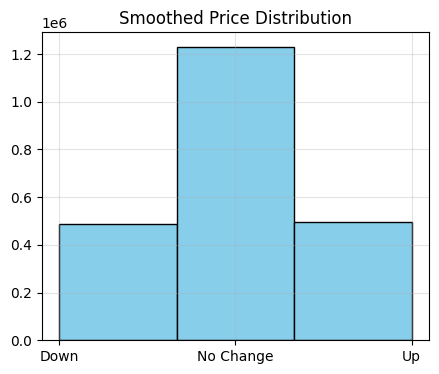

In [15]:
# Distribution of smoothed labels
plt.figure(figsize=(5, 4))
plt.hist(eth_book['SmoothedPriceMove'], bins=3, color='skyblue', edgecolor='black')
plt.title('Smoothed Price Distribution')
plt.xticks([-1, 0, 1], labels=['Down', 'No Change', 'Up'])
plt.grid(alpha=0.35)
plt.show()

A clear improvement on imbalance

### Prepare the features and scale the data

In [16]:
target_col = 'SmoothedPriceMove'

# Selected features
feature_cols = [
    'AskVolume_1', 'AskVolume_2', 'BidVolume_1', 'BidVolume_2',
    'AskVolume_3to10', 'BidVolume_3to10',
    'BidPrice_1','AskPrice_1','BidPrice_2','AskPrice_2',
    'Imbalance_Total','BidArrivalRate','AskArrivalRate',
    'TradeVolume_Buy','TradeVolume_Sell','NumTrades_Buy','NumTrades_Sell',
    'BinanceLargeTradeCount','Spread','RelativeSpread','Microprice','VWAP',
    'Lagged_BinanceTotalVolume','Lagged_BinanceLargeTradeCount'
]

# Add the new rolling sum and event flag features
for w in window_sizes:
    feature_cols.append(f'BinanceTotalVolume_rollingSum_{w}')
    feature_cols.append(f'BinanceLargeTradeCount_rollingSum_{w}')
    feature_cols.append(f'LargeTrade_flag_{w}')

X = eth_book[feature_cols].fillna(0)
y = eth_book[target_col]

print(f"Total NaN values in the dataset: {X.isna().sum().sum()}")

Total NaN values in the dataset: 0


In [17]:
# Train-test split and scaling
train_size = int(0.8 * len(X))
X_train_raw, X_test_raw = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

## Baseline Models: Logistic \& Ridge

We start with simpler Logistic regression and Ridge classifier to establish a performance baseline.

--- Evaluating Logistic Regression ---
Classification Report:
               precision    recall  f1-score   support

          -1     0.6576    0.3325    0.4417    111249
           0     0.5828    0.9632    0.7262    219096
           1     0.8549    0.1873    0.3072    112695

    accuracy                         0.6075    443040
   macro avg     0.6984    0.4943    0.4917    443040
weighted avg     0.6708    0.6075    0.5482    443040

Accuracy: 0.6075


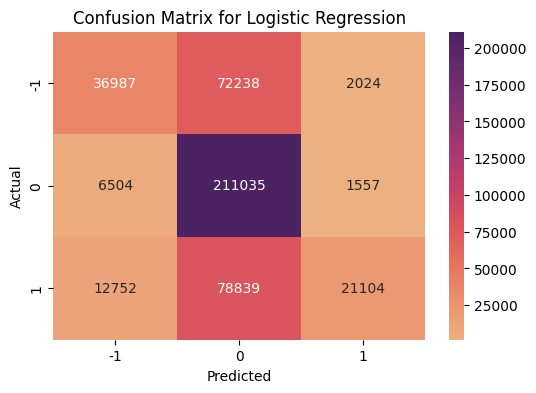

--- Evaluating Ridge Classifier ---
Classification Report:
               precision    recall  f1-score   support

          -1     0.6698    0.2971    0.4116    111249
           0     0.5653    0.9538    0.7099    219096
           1     0.7953    0.1696    0.2796    112695

    accuracy                         0.5894    443040
   macro avg     0.6768    0.4735    0.4671    443040
weighted avg     0.6501    0.5894    0.5256    443040

Accuracy: 0.5894


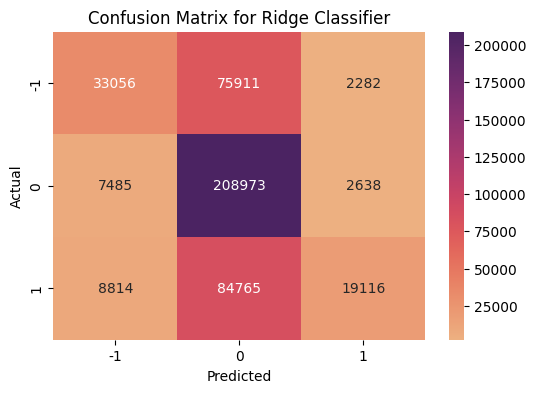

In [19]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=666, n_jobs=-1),
    'Ridge Classifier': RidgeClassifier(random_state=666),
}

def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}\n")
    return y_pred

trained_models = {}

for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    y_pred = model.predict(X_test_scaled)
    conf = confusion_matrix(y_test, y_pred)
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    plt.figure(figsize=(6,4))
    sns.heatmap(conf, annot=True, fmt='d', cmap='flare', xticklabels=[-1,0,1], yticklabels=[-1,0,1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

#### Feature importance for the baseline models

In [20]:
# Feature Importance
for model_name in ['Ridge Classifier', 'Logistic Regression']:
    model = trained_models[model_name]
    
    # Validate coefficients shape
    if not hasattr(model, 'coef_'):
        print(f"Model {model_name} does not have coefficients to analyze.")
        continue
    
    coefficients = model.coef_  # Shape: (n_classes, n_features)
    if coefficients.shape[1] != len(feature_cols):
        print(f"Feature length mismatch in {model_name}: "
              f"{coefficients.shape[1]} coefficients vs {len(feature_cols)} features.")
        continue
    
    # Loop through each class
    for class_idx, class_coefficients in enumerate(coefficients):
        class_name = f"Class {class_idx - 1}"  # Replace with actual class labels if necessary
        
        # Pair coefficients with features
        coeff_df = pd.DataFrame({
            'Feature': feature_cols,
            'Coefficient': class_coefficients
        })
        coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
        
        print(f"\n=== Top Features for {class_name} in {model_name} ===") 
        
        # Top positive features
        print("\nTop Positive Features:")
        print(coeff_df.head(10).to_string(index=False))
        
        # Top negative features
        print("\nTop Negative Features:")
        print(coeff_df.tail(10).to_string(index=False))
    
    # Aggregate feature importance across classes (absolute coefficients)
    global_importance = np.sum(np.abs(coefficients), axis=0)
    global_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'GlobalImportance': global_importance
    })
    global_importance_df = global_importance_df.sort_values(by='GlobalImportance', ascending=False)
    
    print(f"\n=== Global Feature Importance for {model_name} ===")
    print(global_importance_df.head(10).to_string(index=False))


=== Top Features for Class -1 in Ridge Classifier ===

Top Positive Features:
               Feature  Coefficient
                  VWAP    43.400057
            AskPrice_2    39.859232
            BidPrice_1     8.609574
            AskPrice_1     8.608712
        RelativeSpread     0.718196
       BidVolume_3to10     0.023602
           AskVolume_2     0.009075
    LargeTrade_flag_20     0.007466
        BidArrivalRate     0.005694
BinanceLargeTradeCount     0.004028

Top Negative Features:
        Feature  Coefficient
TradeVolume_Buy    -0.007108
    BidVolume_2    -0.017200
 AskArrivalRate    -0.032880
    BidVolume_1    -0.062142
    AskVolume_1    -0.118629
AskVolume_3to10    -0.204045
Imbalance_Total    -0.344401
         Spread    -0.672857
     BidPrice_2   -39.496044
     Microprice   -60.970744

=== Top Features for Class 0 in Ridge Classifier ===

Top Positive Features:
        Feature  Coefficient
     BidPrice_2    85.174295
     Microprice     5.640620
         Spread  

***
# <center> Neural Network
## Long Short Term Memory Recurrent Neural Network


We choose an LSTM model to capture time-dependent patterns in high-frequency order book data. Given a sequence of features $(X_t, X_{t+1}, \dots, X_{t+W})$, a standard feed-forward model ignores the temporal correlation. The LSTM incorporates hidden states $ h_t $ and cell states $ c_t $ that evolve over time, allowing us to model
$$
    h_t, c_t = \text{LSTM}(X_t, h_{t-1}, c_{t-1})
$$
This structure can capture more complex dynamics such as momentum, mean reversion, or order flow pressure.
***

In [18]:
#################
# Pre-Training  #
#################
# Constants
WINDOW_SIZE = 600  # One minute
BATCH_SIZE = 256

# Mapping labels
unique_labels = np.unique(y_train)
label_map = {val: idx for idx, val in enumerate(sorted(unique_labels))}
inv_label_map = {v: k for k, v in label_map.items()}

# Sequence generator
def sequence_generator(X, y, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
    n_samples = len(X)
    max_start = n_samples - window_size + 1
    i = 0
    while True:
        X_batch = np.zeros((batch_size, window_size, X.shape[1]), dtype=np.float16)
        y_batch = np.zeros(batch_size, dtype=int)
        
        for b in range(batch_size):
            if i >= max_start:
                i = 0
            X_batch[b] = X[i:i+window_size].astype(np.float16)
            y_batch[b] = label_map[y.iloc[i+window_size-1]]
            i += 1
        
        y_batch_cat = to_categorical(y_batch, num_classes=len(unique_labels))
        yield X_batch, y_batch_cat

# Training and validation generators
train_gen = sequence_generator(X_train_scaled, y_train)
val_gen = sequence_generator(X_test_scaled, y_test)

n_features = X_train_scaled.shape[1]
n_classes = len(unique_labels)

train_steps = (len(X_train_scaled) - WINDOW_SIZE + 1) // BATCH_SIZE
val_steps = (len(X_test_scaled) - WINDOW_SIZE + 1) // BATCH_SIZE

We use Keras Tuner to search for the best hyperparameters: LSTM units, dropout rate, dense layer size, and learning rate.

In [24]:
##########################
# Hyperparameter Tuning  #
##########################

def model_builder(hp):
    model = Sequential()
    # Hyperparameters to tune:
    # - Number of units in LSTM
    # - Dropout rate
    # - Dense layer size

    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Int('dense_units', min_value=16, max_value=128, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    
    # LSTM layer
    model.add(LSTM(lstm_units, input_shape=(WINDOW_SIZE, n_features), return_sequences=False))
    model.add(Dropout(dropout_rate))

    # Dense layer
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(n_classes, activation='softmax'))

    # Hyperparameter for optimizer learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])

    return model

In [25]:
# Create a tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=20,  # Increase number of trials for a thorough search
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='lstm_tuning'
)

# Early stopping for tuning
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

INFO:tensorflow:Reloading Oracle from existing project hyperparam_tuning\lstm_tuning\oracle.json
INFO:tensorflow:Reloading Tuner from hyperparam_tuning\lstm_tuning\tuner0.json


In [26]:
tuner.search(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=5,  # fewer epochs for tuning
    callbacks=[early_stop],
    verbose=1
)

Trial 20 Complete [00h 21m 05s]
val_accuracy: 0.7281358242034912

Best val_accuracy So Far: 0.7393482327461243
Total elapsed time: 06h 47m 26s
INFO:tensorflow:Oracle triggered exit


In [27]:
# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print("LSTM Units:", best_hps.get('lstm_units')) # 96
print("Dense Units:", best_hps.get('dense_units')) # 32
print("Dropout Rate:", best_hps.get('dropout_rate')) # 0.2
print("Learning Rate:", best_hps.get('learning_rate')) # 0.001

Best hyperparameters found:
LSTM Units: 96
Dense Units: 32
Dropout Rate: 0.2
Learning Rate: 0.001


In [28]:
#########################
# Final Model Training  #
#########################

final_model = tuner.hypermodel.build(best_hps)

# Additional callbacks for final training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop_final = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = final_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=10,  # Final training epochs
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[reduce_lr, early_stop_final],
    verbose=1
)

Epoch 1/10
6920/6920 [==============================] - 319s 46ms/step - loss: 0.5816 - accuracy: 0.7731 - val_loss: 0.7289 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 2/10
6920/6920 [==============================] - 322s 46ms/step - loss: 0.5367 - accuracy: 0.7963 - val_loss: 0.7172 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 3/10
6920/6920 [==============================] - 301s 44ms/step - loss: 0.5221 - accuracy: 0.8023 - val_loss: 0.7185 - val_accuracy: 0.7145 - lr: 0.0010
Epoch 4/10
6920/6920 [==============================] - 311s 45ms/step - loss: 0.5135 - accuracy: 0.8061 - val_loss: 0.7204 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 5/10
6920/6920 [==============================] - 361s 52ms/step - loss: 0.5069 - accuracy: 0.8090 - val_loss: 0.6856 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 6/10
6920/6920 [==============================] - 577s 83ms/step - loss: 0.5016 - accuracy: 0.8111 - val_loss: 0.7011 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 7/10
6920/6920 [==================

In [19]:
#########################
# Evaluation on Test Set
#########################

def evaluate_model_with_generator(model, generator, steps, y_true, inv_map):
    y_pred_probs = []
    y_true_labels = []
    # To ensure consistent test evaluation, recreate the generator or iterate similarly
    # It's important that test_gen yields the exact same samples every time
    # If not, ensure test_gen is deterministic or create a separate deterministic sequence generator.

    # Create a stable test generator if needed:
    test_gen = sequence_generator(X_test_scaled, y_test)
    for _ in range(steps):
        X_batch, y_batch = next(test_gen)
        y_pred_probs.append(model.predict(X_batch, verbose=0))
        y_true_labels.append(y_batch)
    y_pred_probs = np.vstack(y_pred_probs)
    y_true_labels = np.vstack(y_true_labels)

    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_true_labels, axis=1)

    y_pred_original = np.array([inv_map[val] for val in y_pred])
    y_true_original = np.array([inv_map[val] for val in y_true])

    acc = accuracy_score(y_true_original, y_pred_original)
    return acc, y_pred_original, y_true_original

Optimized LSTM Model Classification Report:
              precision    recall  f1-score   support

          -1     0.7322    0.6547    0.6912    111180
           0     0.7195    0.9251    0.8094    218604
           1     0.9011    0.4951    0.6391    112584

    accuracy                         0.7477    442368
   macro avg     0.7842    0.6916    0.7133    442368
weighted avg     0.7689    0.7477    0.7364    442368



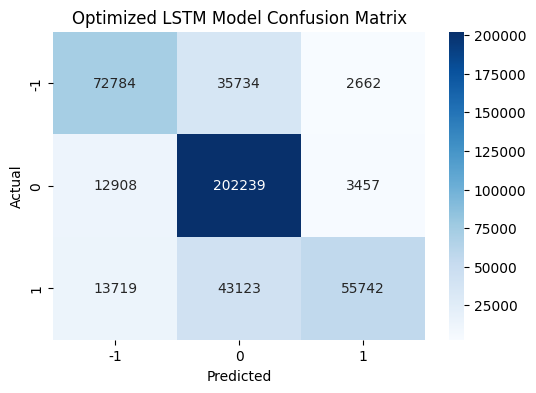

Optimized LSTM Model Accuracy: 0.7477


In [29]:
test_gen_for_eval = sequence_generator(X_test_scaled, y_test)
acc, y_pred_original, y_true_original = evaluate_model_with_generator(final_model, test_gen_for_eval, val_steps, y_test, inv_label_map)

print("Optimized LSTM Model Classification Report:")
print(classification_report(y_true_original, y_pred_original, digits=4))

conf = confusion_matrix(y_true_original, y_pred_original)
plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(unique_labels), yticklabels=sorted(unique_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized LSTM Model Confusion Matrix')
plt.show()

print(f"Optimized LSTM Model Accuracy: {acc:.4f}")

- **Precision**:  
  $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$  
  Precision measures how often the model’s positive predictions are correct. Higher precision $\implies
  $ fewer false alarms.

- **Recall**:  
  $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$  
  Recall measures how often the model correctly identifies positive instances out of all actual positives. High recall $\implies$ the model misses fewer positive cases.

- **F1-Score**:  
  $$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$  
  The harmonic mean of precision and recall, providing a single metric that balances both. A higher F1-score indicates a better balance between precision and recall.

- **Support**:  
  The number of actual occurrences of each class in the test dataset.

- **Accuracy**:  
  $$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$  

In this report:
- The neutral class achieves a relatively high recall, indicating the model is quite good at identifying periods of no significant price change.
- The upward class has a high precision but lower recall, suggesting it is more cautious in predicting upward moves, yet when it predicts an upward move, it is often correct.
- An accuracy of 0.7477 means that about 74.77% of the time, the model’s predictions match the actual price movement direction.

***
### Final LSTM model with tuned paramters

In [21]:
# Best hyperparameters found
# LSTM Units: 96
# Dense Units: 32
# Dropout Rate: 0.2
# Learning Rate: 0.001

model = Sequential([
    LSTM(96, input_shape=(WINDOW_SIZE, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Training the model
train_steps = (len(X_train_scaled) - WINDOW_SIZE + 1) // BATCH_SIZE
val_steps = (len(X_test_scaled) - WINDOW_SIZE + 1) // BATCH_SIZE

In [23]:
# Model training
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/10
6920/6920 [==============================] - 321s 46ms/step - loss: 0.5855 - accuracy: 0.7705 - val_loss: 0.7273 - val_accuracy: 0.7064
Epoch 2/10
6920/6920 [==============================] - 315s 46ms/step - loss: 0.5368 - accuracy: 0.7961 - val_loss: 0.6985 - val_accuracy: 0.7220
Epoch 3/10
6920/6920 [==============================] - 312s 45ms/step - loss: 0.5216 - accuracy: 0.8024 - val_loss: 0.7020 - val_accuracy: 0.7226
Epoch 4/10
6920/6920 [==============================] - 313s 45ms/step - loss: 0.5128 - accuracy: 0.8064 - val_loss: 0.6799 - val_accuracy: 0.7313
Epoch 5/10
6920/6920 [==============================] - 315s 46ms/step - loss: 0.5063 - accuracy: 0.8088 - val_loss: 0.6804 - val_accuracy: 0.7315
Epoch 6/10
6920/6920 [==============================] - 316s 46ms/step - loss: 0.5016 - accuracy: 0.8109 - val_loss: 0.6378 - val_accuracy: 0.7461
Epoch 7/10
6920/6920 [==============================] - 316s 46ms/step - loss: 0.4969 - accuracy: 0.8128 - val_loss: 0

LSTM Model Classification Report:
              precision    recall  f1-score   support

          -1     0.7242    0.6640    0.6928    111180
           0     0.7317    0.9185    0.8145    218604
           1     0.8865    0.5199    0.6555    112584

    accuracy                         0.7531    442368
   macro avg     0.7808    0.7008    0.7209    442368
weighted avg     0.7692    0.7531    0.7434    442368



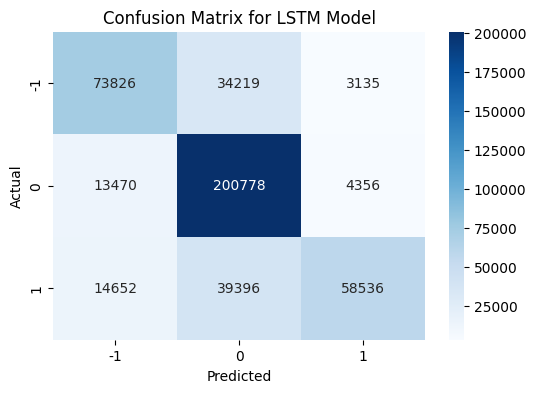

LSTM Model Accuracy: 0.7531


In [24]:
# Evaluate the model
def evaluate_model_with_generator(model, generator, steps, y_true, inv_map):
    y_pred_probs = []
    y_true_labels = []
    for _ in range(steps):
        X_batch, y_batch = next(generator)
        y_pred_probs.append(model.predict(X_batch, verbose=0))
        y_true_labels.append(y_batch)
    y_pred_probs = np.vstack(y_pred_probs)
    y_true_labels = np.vstack(y_true_labels)

    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_true_labels, axis=1)

    y_pred_original = np.array([inv_map[val] for val in y_pred])
    y_true_original = np.array([inv_map[val] for val in y_true])

    acc = accuracy_score(y_true_original, y_pred_original)
    return acc, y_pred_original, y_true_original
test_gen = sequence_generator(X_test_scaled, y_test)
acc, y_pred_original, y_true_original = evaluate_model_with_generator(model, test_gen, val_steps, y_test, inv_label_map)

print("LSTM Model Classification Report:")
print(classification_report(y_true_original, y_pred_original, digits=4))

conf = confusion_matrix(y_true_original, y_pred_original)
plt.figure(figsize=(6, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(unique_labels), yticklabels=sorted(unique_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

print(f"LSTM Model Accuracy: {acc:.4f}")

In [21]:
# Save the trained LSTM model
model.save('lstm_model.h5')

# Save the scaler as well, so we can use it during live inference 
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']